In [1]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on PyTorch {torch.__version__}')
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

Running on PyTorch 1.12.1


In [2]:
def hifi_function(x):
    return (0.1 * torch.sin(40 * x) + (((2 * x) ** 2) / 3)).squeeze().clone().detach()

def outcome_constraint(X):
    """L1 constraint; feasible if less than or equal to zero."""
    return X.sum(dim=-1) - 3

def weighted_obj(X):
    """Feasibility weighted objective; zero if not feasible."""
    return hifi_function(X) * (outcome_constraint(X) <= 0).type_as(X)

from botorch.models import FixedNoiseGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

NOISE_SE = 0.5
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)

def generate_initial_data(n=10):
    # generate training data
    train_x = torch.rand(n, 1, device=device, dtype=dtype)
    exact_obj = hifi_function(train_x).unsqueeze(-1)  # add output dimension
    exact_con = outcome_constraint(train_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    train_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    best_observed_value = weighted_obj(train_x).max().item()
    return train_x, train_obj, train_con, best_observed_value

In [3]:
def initialize_model(train_x, train_obj, train_con, state_dict=None):
    # define models for objective and constraint
    model_obj = FixedNoiseGP(train_x, train_obj, train_yvar.expand_as(train_obj)).to(
        train_x
    )
    model_con = FixedNoiseGP(train_x, train_con, train_yvar.expand_as(train_con)).to(
        train_x
    )
    # combine into a multi-output GP model
    model = ModelListGP(model_obj, model_con)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

In [4]:
from botorch.acquisition.objective import ConstrainedMCObjective


def obj_callable(Z):
    return Z[..., 0]


def constraint_callable(Z):
    return Z[..., 1]


# define a feasibility-weighted objective for optimization
constrained_obj = ConstrainedMCObjective(
    objective=obj_callable,
    constraints=[constraint_callable],
)

In [5]:
from botorch.optim import optimize_acqf


bounds = torch.tensor([[0.0] * 1, [1.0] * 1], device=device, dtype=dtype)

BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    exact_obj = hifi_function(new_x).unsqueeze(-1)  # add output dimension
    exact_con = outcome_constraint(new_x).unsqueeze(-1)  # add output dimension
    new_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    new_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    return new_x, new_obj, new_con


def update_random_observations(best_random):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(BATCH_SIZE, 1)
    next_random_best = weighted_obj(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))
    return best_random

In [6]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
)
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning

import time
import warnings


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 256 if not SMOKE_TEST else 32

verbose = False

best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []


# average over multiple trials
for trial in range(1, N_TRIALS + 1):

   print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
   best_observed_ei, best_observed_nei, best_random = [], [], []

   # call helper functions to generate initial training data and initialize model
   (
        train_x_ei,
        train_obj_ei,
        train_con_ei,
        best_observed_value_ei,
    ) = generate_initial_data(n=10)
   mll_ei, model_ei = initialize_model(train_x_ei, train_obj_ei, train_con_ei)

   train_x_nei, train_obj_nei, train_con_nei = train_x_ei, train_obj_ei, train_con_ei
   best_observed_value_nei = best_observed_value_ei
   mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei, train_con_nei)

   best_observed_ei.append(best_observed_value_ei)
   best_observed_nei.append(best_observed_value_nei)
   best_random.append(best_observed_value_ei)

   # run N_BATCH rounds of BayesOpt after the initial random batch
   for iteration in range(1, N_BATCH + 1):

        t0 = time.monotonic()

        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_nei)

        # define the qEI and qNEI acquisition modules using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

        # for best_f, we use the best observed noisy values as an approximation
        qEI = qExpectedImprovement(
            model=model_ei,
            best_f=(train_obj_ei * (train_con_ei <= 0).to(train_obj_ei)).max(),
            sampler=qmc_sampler,
            objective=constrained_obj,
        )

        qNEI = qNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
            objective=constrained_obj,
        )

        # optimize and get new observation
        new_x_ei, new_obj_ei, new_con_ei = optimize_acqf_and_get_observation(qEI)
        new_x_nei, new_obj_nei, new_con_nei = optimize_acqf_and_get_observation(qNEI)
        
        # print(f"Iter {iter+1}/{N_ITER} - next points: {new_X}\n pred objectives: {predicted_optimal_obj}")

        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])
        train_con_ei = torch.cat([train_con_ei, new_con_ei])

        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        train_con_nei = torch.cat([train_con_nei, new_con_nei])

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = weighted_obj(train_x_ei).max().item()
        best_value_nei = weighted_obj(train_x_nei).max().item()
        best_observed_ei.append(best_value_ei)
        best_observed_nei.append(best_value_nei)

        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        mll_ei, model_ei = initialize_model(
            train_x_ei,
            train_obj_ei,
            train_con_ei,
            model_ei.state_dict(),
        )
        mll_nei, model_nei = initialize_model(
            train_x_nei,
            train_obj_nei,
            train_con_nei,
            model_nei.state_dict(),
        )

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI, qNEI) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}, {best_value_nei:>4.2f}), "
                f"time = {t1-t0:>4.2f}.",
                end="",
            )
        else:
            print(".", end="")
    
    
   best_observed_all_ei.append(best_observed_ei)
   best_observed_all_nei.append(best_observed_nei)
   best_random_all.append(best_random)


Trial  1 of 3 ....................
Trial  2 of 3 ....................
Trial  3 of 3 ....................

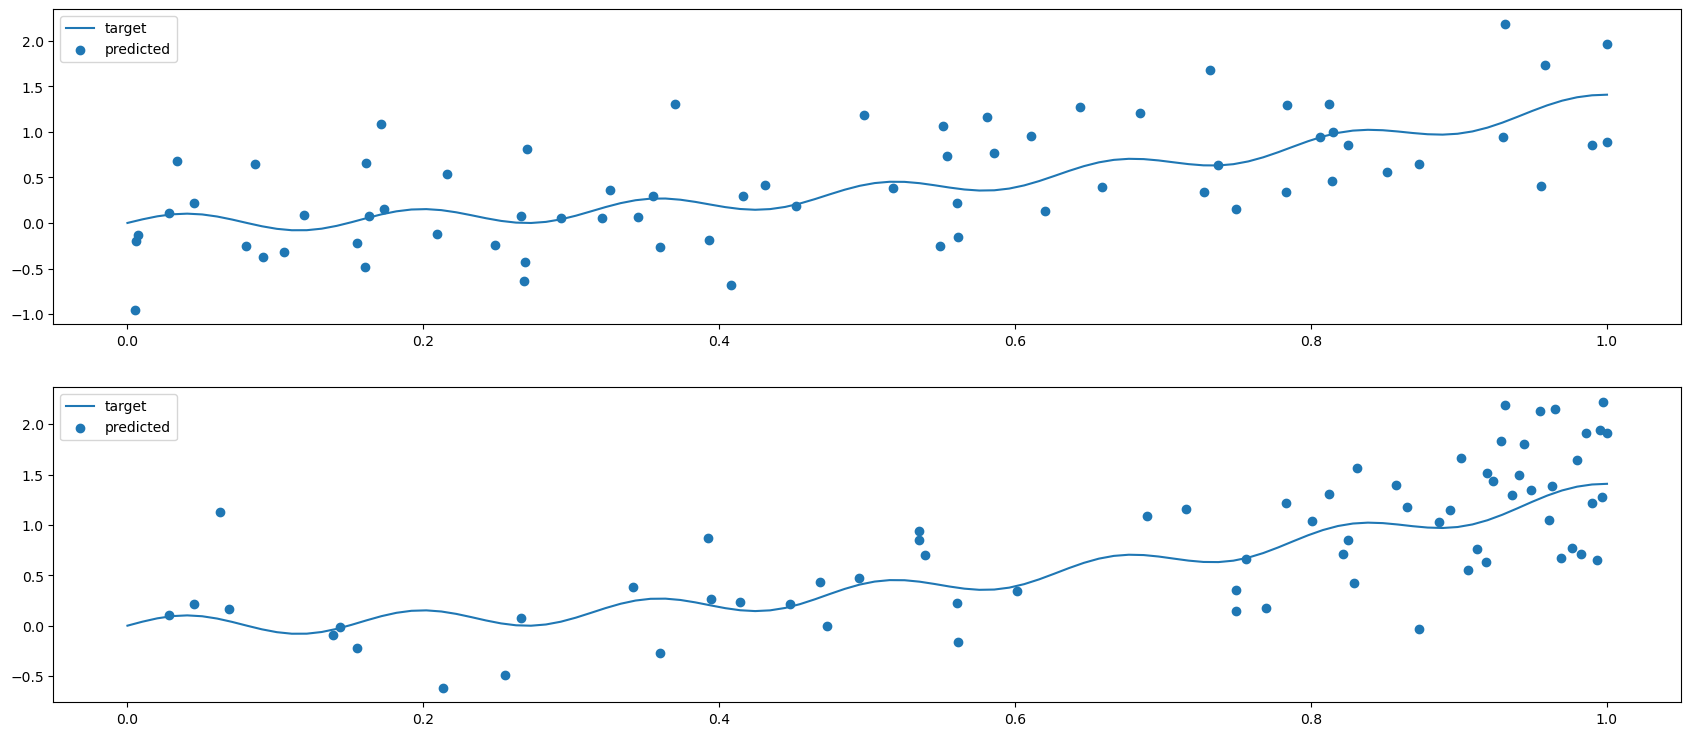

In [7]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(21, 9))
test_x = torch.linspace(0, 1, 100)
ax = fig.add_subplot(2, 1, 1)
ax.plot(test_x.numpy(), hifi_function(test_x).numpy(),label = 'target')
ax.scatter(train_x_ei.numpy(), train_obj_ei.numpy(),label = 'predicted')
plt.legend()

ax = fig.add_subplot(2, 1, 2)
ax.plot(test_x.numpy(), hifi_function(test_x).numpy(),label = 'target')
ax.scatter(train_x_nei.numpy(), train_obj_nei.numpy(),label = 'predicted')
plt.legend()

In [8]:
import gpytorch
from gpytorch.models import ExactGP
# Define the Kernel of Gaussian Process
class ExactGPModel(ExactGP):
    def __init__(self,X_train, Y_train,likelihood):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

ei - Iter 100/1000 - Loss: 0.96024 LenghtParam 0.73274
ei - Iter 200/1000 - Loss: 0.93843 LenghtParam 0.73563
ei - Iter 300/1000 - Loss: 0.91790 LenghtParam 0.71280
ei - Iter 400/1000 - Loss: 0.89886 LenghtParam 0.68455
ei - Iter 500/1000 - Loss: 0.88155 LenghtParam 0.65839
ei - Iter 600/1000 - Loss: 0.86616 LenghtParam 0.63665
ei - Iter 700/1000 - Loss: 0.85278 LenghtParam 0.61999
ei - Iter 800/1000 - Loss: 0.84142 LenghtParam 0.60829
ei - Iter 900/1000 - Loss: 0.83202 LenghtParam 0.60106
ei - Iter 1000/1000 - Loss: 0.82445 LenghtParam 0.59762




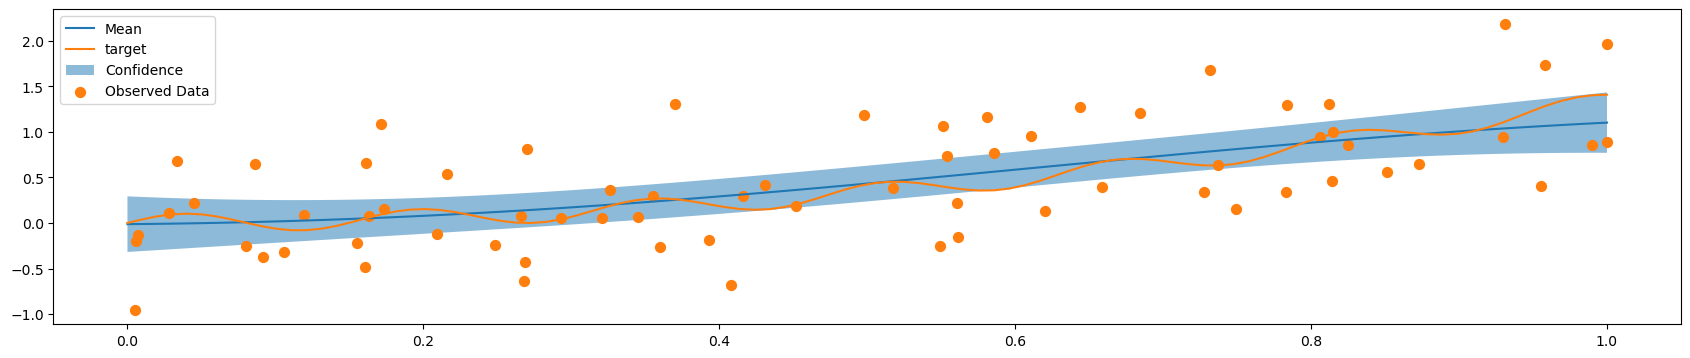

In [9]:
fig = plt.figure()

# FIT THE MODEL
likelihood = gpytorch.likelihoods.GaussianLikelihood()
    # Define the model
    #gp_model = SingleTaskGP(X_lofi[2:,alpha].unsqueeze(-1) , Y_lofi[2:], likelihood = likelihood  )
gp_model = ExactGPModel(train_x_ei , train_obj_ei.squeeze(), likelihood)
    # Find optimal model hyperparameters
gp_model.train()
likelihood.train()
optimizer = torch.optim.Adam(gp_model.parameters(),lr=1e-3) # Use the adam optimizer  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model) # "Loss" for GPs - the marginal log likelihood
    #mll = gpytorch.mlls.LeaveOneOutPseudoLikelihood(likelihood, gp_model) # "Loss" for GPs - LOO Pseudo likelihood

training_iter  = 1000 if not SMOKE_TEST else 4
for i in range(training_iter):
    optimizer.zero_grad()    # Zero gradients from previous iteration
    output = gp_model(train_x_ei)        # Output from model
    loss = -mll(output, train_obj_ei.squeeze())     # compute loss and backprop gradients
    loss.backward()
    if (i+1) % 100 == 0:
        print(f'ei - Iter {i + 1}/{training_iter} - Loss: {loss.item():.5f} LenghtParam {gp_model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0]:.5f}')
    optimizer.step()
print('\n')

gp_model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100).double()
    observed_pred = (gp_model(test_x))      # Make predictions by feeding model through likelihood
    ax = fig.add_subplot(2, 1, 1)      # Initialize plot
    lower, upper = observed_pred.confidence_region()     # Get upper and lower confidence bounds
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), label = 'Mean')     # Plot predictive means as blue line
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence')  # Shade between the lower and upper confidence bounds
    ax.plot(test_x.numpy(), hifi_function(test_x).numpy(),label = 'target')
    ax.scatter(train_x_ei.numpy(), train_obj_ei.numpy(), s=50,label = 'Observed Data')
    ax.legend()
    # DECREASE VARIANCE
plt.show()